# Strategy Backtesting

This notebook evaluate the performance of our momentum based strategy using historical market data to simulate real-world execution.

In [1]:
# requirements 

import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import Gateway as gw # Gateway class reads and feeds market data into the system incrementally
import MatchingEngine as me # MatchingEngine class simulates order matching and execution outcomes
import OrderBook as obk # OrderBook class manages orders and trades
import Momentum as mm # Momentum strategy implementation
import OrderManager as om  # OrderManager class for order validation and management
import uuid

Example 1:
We receive these orders:
Processing orders...
Resulting order book:


### Data Acquisition and Setup 

In [2]:
fp = 'cleaned/AAPL_7d.csv'
streamer = gw.Gateway(fp)
engine = me.MatchingEngine()
book = obk.OrderBook()
order_manager = om.OrderManager()

### Simulation Execution 

- Feed historical data through the Gateway to simulate a live environment.
- Generate and process orders based on strategy signals.
- Use the Matching Engine to simulate fills, partial fills, and cancellations.

In [3]:
df = pd.read_csv(fp)
df.set_index('Datetime', inplace=True)
strat = mm.Momentum(df)
signals = strat.run()

market_data = streamer.stream_data()
print(market_data)

print(signals)

# print(df)

{'2025-11-10 14:30:00+00:00': {'Ticker': 'AAPL', 'Price': 270.125}, '2025-11-10 14:31:00+00:00': {'Ticker': 'AAPL', 'Price': 270.4599914550781}, '2025-11-10 14:32:00+00:00': {'Ticker': 'AAPL', 'Price': 271.06500244140625}, '2025-11-10 14:33:00+00:00': {'Ticker': 'AAPL', 'Price': 271.5350036621094}, '2025-11-10 14:34:00+00:00': {'Ticker': 'AAPL', 'Price': 271.54949951171875}, '2025-11-10 14:35:00+00:00': {'Ticker': 'AAPL', 'Price': 272.1099853515625}, '2025-11-10 14:36:00+00:00': {'Ticker': 'AAPL', 'Price': 272.0398864746094}, '2025-11-10 14:37:00+00:00': {'Ticker': 'AAPL', 'Price': 271.7569885253906}, '2025-11-10 14:38:00+00:00': {'Ticker': 'AAPL', 'Price': 271.4599914550781}, '2025-11-10 14:39:00+00:00': {'Ticker': 'AAPL', 'Price': 271.760009765625}, '2025-11-10 14:40:00+00:00': {'Ticker': 'AAPL', 'Price': 271.42498779296875}, '2025-11-10 14:41:00+00:00': {'Ticker': 'AAPL', 'Price': 271.4800109863281}, '2025-11-10 14:42:00+00:00': {'Ticker': 'AAPL', 'Price': 271.3399963378906}, '2025-

In [4]:
pnls = {}  # key = time, value = pnl at that time 

for time in signals.keys():
    dt_time = pd.to_datetime(time)
    order_id = f"order_{time}_{uuid.uuid4()}" 
    price = market_data[time]['Price']
    sig = signals[time]
    size = 1 
    side = 'Buy' 
    
    if sig == -1: 
        side = 'Sell'
    elif sig == 0:
        side = 'Hold'

    order = obk.Order(order_id, price, size, side, dt_time)
    
    validation_response = order_manager.validate_order(order)

    if validation_response[0] == False:
        print(f"Order {order.order_id} is invalid: {validation_response}")
        continue


    book.add(order)
    book.process(order)
    print(f"Added order: {order.order_id}, Side: {order.side}, Price: {order.price}, Size: {order.size}, Time: {order.time}")
    streamer.log_order(order, action="Added")
    order_manager.record_order(order)

    pnl = order_manager.available_capital - (order_manager.current_position * order.price)
    pnls[dt_time] = pnl 

Order order_2025-11-10 14:30:00+00:00_e8b427da-8ef1-40c3-a5fb-acf7f62606aa added to book.
Added order: order_2025-11-10 14:30:00+00:00_e8b427da-8ef1-40c3-a5fb-acf7f62606aa, Side: Hold, Price: 270.125, Size: 1, Time: 2025-11-10 14:30:00+00:00
Order order_2025-11-10 14:31:00+00:00_7e1a5ab0-9bca-4196-b7c5-46ca07b4c3a5 added to book.
Added order: order_2025-11-10 14:31:00+00:00_7e1a5ab0-9bca-4196-b7c5-46ca07b4c3a5, Side: Hold, Price: 270.4599914550781, Size: 1, Time: 2025-11-10 14:31:00+00:00
Order order_2025-11-10 14:32:00+00:00_2c36c752-88fe-432a-9d90-9b36fcfb76f9 added to book.
Added order: order_2025-11-10 14:32:00+00:00_2c36c752-88fe-432a-9d90-9b36fcfb76f9, Side: Hold, Price: 271.06500244140625, Size: 1, Time: 2025-11-10 14:32:00+00:00
Order order_2025-11-10 14:33:00+00:00_f83d892e-d6f7-4ca9-9a92-1f1957310bc9 added to book.
Added order: order_2025-11-10 14:33:00+00:00_f83d892e-d6f7-4ca9-9a92-1f1957310bc9, Side: Hold, Price: 271.5350036621094, Size: 1, Time: 2025-11-10 14:33:00+00:00
O

### Performance Tracking

- Record executed trades, timestamps, prices, and volumes.
- Calculate key metrics: P&L, Sharpe ratio, drawdown, win/loss ratio, etc.

In [5]:
def display_stats (market_data):
    pnl = order_manager.available_capital - order_manager.current_position * market_data[order_manager.current_minute]['Price']
    print(f"Initial Capital: {order_manager.initial_capital}")
    print(f"Available Capital: {order_manager.available_capital}")
    print(f"Current Position Size: {order_manager.current_position}")
    print(f"Total Orders Executed: {len(order_manager.orders_executed)}")
    print(f"PnL: {pnl}")
    return pnl

### Reporting 

- Visualize equity curve, trade distribution, and performance statistics.
- Compare strategy variants and parameter sensitivity.

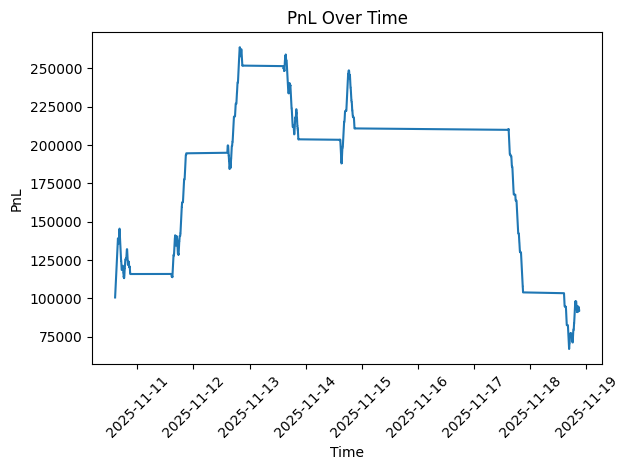

In [6]:
# plotting PnL over time
pnl_values = list(pnls.values())
pnl_times = list(pnls.keys())
plt.plot(pnl_times, pnl_values)
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('PnL Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='Time'>

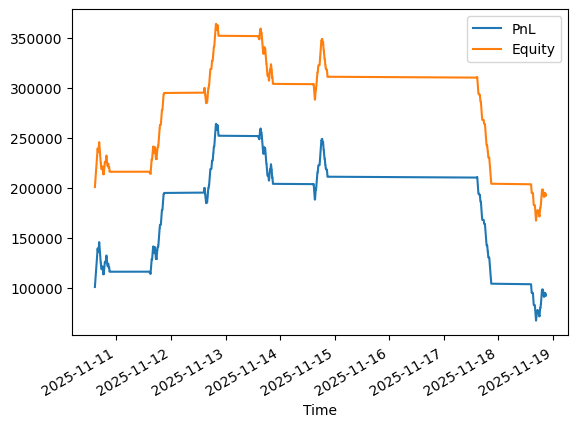

In [7]:
def generate_equity_curve(): 
    equity_curve = pd.DataFrame(list(pnls.items()), columns=['Time', 'PnL'])
    equity_curve.set_index('Time', inplace=True)
    equity_curve['Equity'] = equity_curve['PnL'] + order_manager.initial_capital
    return equity_curve

# generate_equity_curve()
generate_equity_curve().plot()

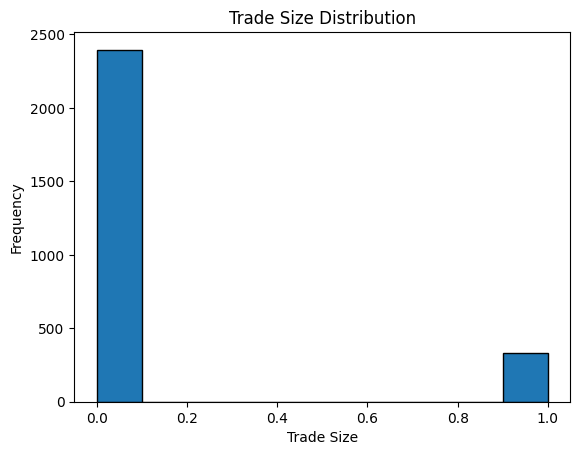

In [8]:
def find_trade_distribution():
    trade_sizes = [order.size for order in order_manager.orders_executed]
    plt.hist(trade_sizes, bins=10, edgecolor='black')
    plt.xlabel('Trade Size')
    plt.ylabel('Frequency')
    plt.title('Trade Size Distribution')
    plt.show()

find_trade_distribution()

In [9]:
def performance_statistics(): 
    total_trades = len(order_manager.orders_executed)
    winning_trades = [order for order in order_manager.orders_executed if order.side == 'Sell' and order.price > order_manager.get_buy_price()]
    losing_trades = [order for order in order_manager.orders_executed if order.side == 'Sell' and order.price <= order_manager.get_buy_price()]
    
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    avg_win = np.mean([order.price - order_manager.get_buy_price() for order in winning_trades]) if winning_trades else 0
    avg_loss = np.mean([order_manager.get_buy_price() - order.price for order in losing_trades]) if losing_trades else 0
    
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {len(winning_trades)}")
    print(f"Losing Trades: {len(losing_trades)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Winning Trade: {avg_win:.2f}")
    print(f"Average Losing Trade: {avg_loss:.2f}")

performance_statistics()


Total Trades: 2730
Winning Trades: 0
Losing Trades: 1368
Win Rate: 0.00%
Average Winning Trade: 0.00
Average Losing Trade: 1419.30
